In [6]:
#Load libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [13]:
import os
import re
from torchvision.io import read_image, ImageReadMode
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        self.file_paths = []
        self.label_map = {'not_car': 0, 'car': 1}
        self.classes = labels
        
        for lab in self.labels:
            label_folder = os.path.join(str(img_dir), lab)
            file_list = [os.path.join(label_folder, file.name) for file in os.scandir(label_folder) if file.is_file()]
            self.file_paths.extend([(file, lab) for file in file_list])
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path, label = self.file_paths[idx]
        image = read_image(img_path, mode=ImageReadMode.RGB).float() / 255.0 # Scale to [0, 1]
        if self.transform:
            image = self.transform(image)
        label_id = self.label_map[label]
        return image, label_id
        
# Example usage
train_dir = 'D:/MSRSGI/Summer_Semester24/DL/Exercises/Exercise1/WorkingData/data/train'
test_dir = 'D:/MSRSGI/Summer_Semester24/DL/Exercises/Exercise1/WorkingData/data/test'
labels = ['not_car', 'car']  # Ensure this matches your directory structure

# Define the transforms
import torchvision.transforms as transforms

data_transforms = transforms.Compose([
    transforms.Resize((224, 224))
    # transforms.ToTensor()
])

train_dataset = CustomDataset(train_dir, labels, transform = data_transforms) 
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True) #takes an image not a tensor 

test_dataset = CustomDataset(test_dir, labels, transform = data_transforms) 
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True) #takes an image not a tensor

labels:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0])


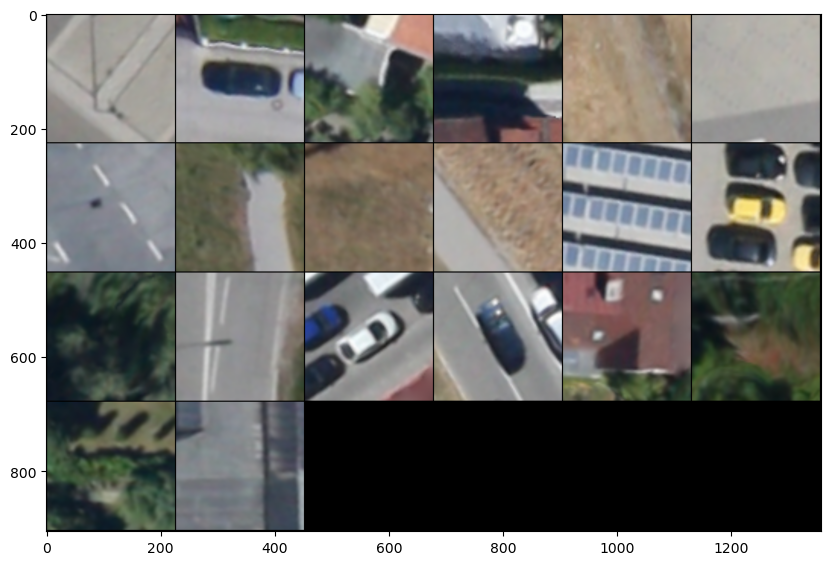

In [14]:
# train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=True) #dataset=images, not a tensor 
# next(iter(train_dataloader))

def show_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 20, shuffle=True) #shuffle=acess data randomly #batch-size  is chosen randomly here
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 6)
    plt.figure(figsize=(10,12))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)
show_images(train_dataset)

tensor(1)  tensor(1)  tensor(1)  tensor(1)


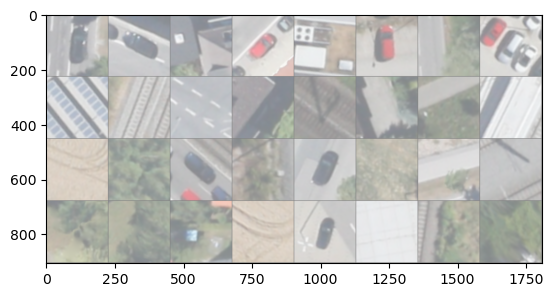

In [8]:
#another way of implementation of next_function to test the dataloader
#images[10], labels[0]    #randoly accessing the images with 0 label (not-car)


# import matplotlib.pyplot as plt
# import numpy as np

# # Helper function for inline image display
# def matplotlib_imshow(img, one_channel=False):
#     if one_channel:
#         img = img.mean(dim=0)
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     if one_channel:
#         plt.imshow(npimg, cmap="plasma")
#     else:
#         plt.imshow(np.transpose(npimg, (1, 2, 0)))

# dataiter = iter(train_dataloader)
# images, labels = next(dataiter)
# # images[10], labels[0]    #randoly accessing the images with 0 label (not-car)

# # Create a grid from the images and show them
# img_grid = torchvision.utils.make_grid(images)
# matplotlib_imshow(img_grid, one_channel=False)
# print('  '.join(str(labels[labels[j]]) for j in range(4)))

In [15]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_image_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_image_count += image_count_in_a_batch
        
    mean /= total_image_count
    std /= total_image_count
    
    return mean, std

# data_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
mean_train, std_train = get_mean_std(train_dataloader)
mean_train, std_train

(tensor([0.4886, 0.4886, 0.4760]), tensor([0.1482, 0.1395, 0.1342]))

In [16]:
batch_size = 32
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
mean_test, std_test = get_mean_std(test_dataloader)
mean_test, std_test

(tensor([0.4670, 0.4365, 0.4319]), tensor([0.1659, 0.1498, 0.1380]))

In [17]:
train_transforms_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_train), torch.Tensor(std_train))])

# dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

train_dataset_norm = CustomDataset(train_dir, labels, transform = train_transforms_norm) 

In [18]:
len(train_dataset_norm)

4200

In [19]:
train_dataloader_norm = torch.utils.data.DataLoader(dataset=train_dataset_norm, batch_size=32, shuffle=True) #takes an image not a tensor 
len(train_dataloader_norm)

132

In [20]:
test_transforms_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_test), torch.Tensor(std_test))])

# dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

test_dataset_norm = CustomDataset(test_dir, labels, transform = test_transforms_norm) 
len(test_dataset_norm)

1346

In [21]:
test_dataloader_norm = torch.utils.data.DataLoader(dataset=test_dataset_norm, batch_size=32, shuffle=True) #takes an image not a tensor 
len(test_dataloader_norm)

43

In [22]:
# test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=32, shuffle=True) #dataset=images, not a tensor 
# next(iter(test_dataloader))

def show_tranformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 6)
    plt.figure(figsize=(11,12))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

labels:  tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0])


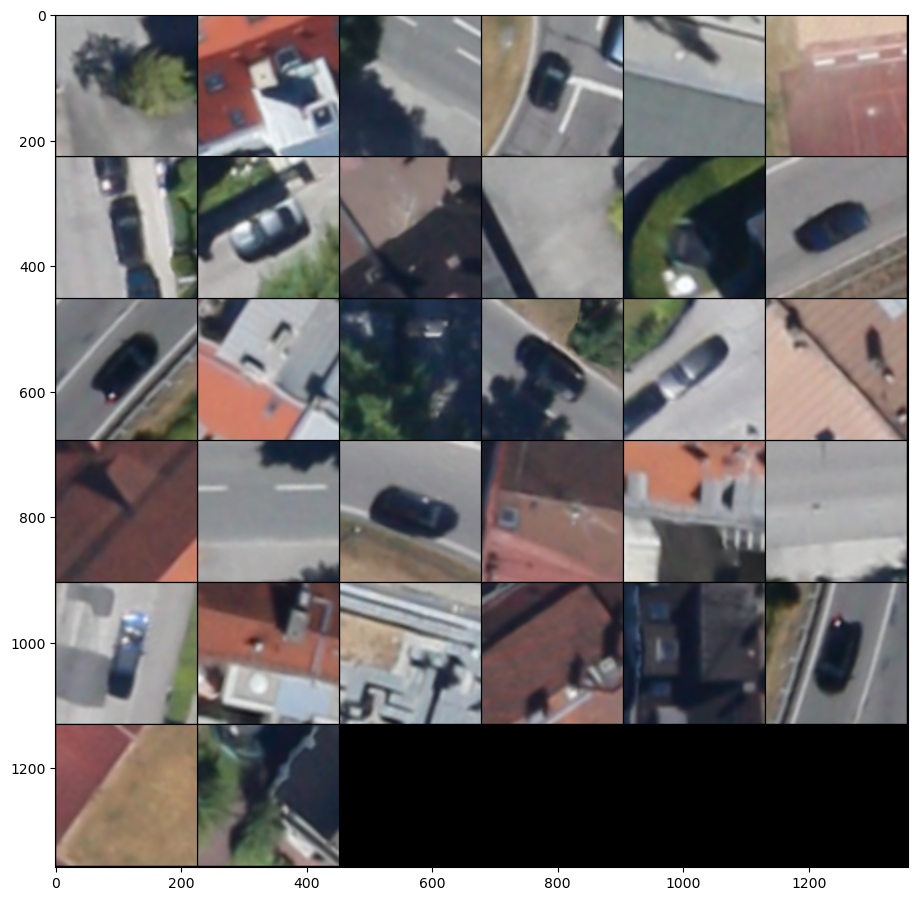

In [23]:
show_tranformed_images(test_dataset)

In [24]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [26]:
#categories
root=pathlib.Path(train_dir)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [28]:
print(classes)

['car', 'not_car']


In [32]:
#CNN Network

class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=5) #I/p = 3 different RGB Channel #O/P=32 kernels
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(32 * 110 * 110, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        # x = x.view(-1, 32 * 110 * 110) #x = x.view(-1, 32*110*110) sounds better if guaranteed the tensor has a feature size of 32*110*110
        x = x.view(x.size(0), -1) #better approach would be to use x = x.view(x.size(0), -1) to make sure the batch size does not change
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [33]:
model=ConvNet(num_classes=6).to(device)

In [34]:
print(model)

ConvNet(
  (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=387200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [39]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)

In [42]:
#Model training and saving best model

num_epochs = 40
batch_size = 32

# n_total_steps = len(train_dataloader_norm)
# n_total_steps

best_accuracy=0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    total_samples = 0.0
    
    for i, (images,labels) in enumerate(train_dataloader_norm):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
                            
        optimizer.zero_grad()
                            
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        total_samples += labels.size(0)
        
        # Print mini-batch statistics
        if (i + 1) % 50 == 0:
            mini_batch_loss = train_loss / total_samples
            mini_batch_accuracy = train_accuracy / total_samples
            print(f"Minibatch Loss: {mini_batch_loss:.4f}  Accuracy: {mini_batch_accuracy:.4f}")
    
    # Calculate average loss and accuracy for the epoch
    epoch_loss = train_loss / len(train_dataloader_norm.dataset)
    epoch_accuracy = train_accuracy / len(train_dataloader_norm.dataset) 
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_dataloader_norm):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    test_accuracy=test_accuracy/len(test_dataloader_norm.dataset)
    
    print(f"Loss: {epoch_loss:.4f}  Accuracy: {epoch_accuracy:.4f}")
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch 1/40
--------------------------------------------------
Minibatch Loss: 0.0805  Accuracy: 0.9688
Minibatch Loss: 0.0670  Accuracy: 0.9750
Loss: 0.0599  Accuracy: 0.9781
Epoch 2/40
--------------------------------------------------
Minibatch Loss: 0.0391  Accuracy: 0.9875
Minibatch Loss: 0.0399  Accuracy: 0.9866
Loss: 0.0416  Accuracy: 0.9860
Epoch 3/40
--------------------------------------------------
Minibatch Loss: 0.0204  Accuracy: 0.9956
Minibatch Loss: 0.0192  Accuracy: 0.9950
Loss: 0.0206  Accuracy: 0.9940
Epoch 4/40
--------------------------------------------------
Minibatch Loss: 0.0129  Accuracy: 0.9981
Minibatch Loss: 0.0127  Accuracy: 0.9978
Loss: 0.0120  Accuracy: 0.9983
Epoch 5/40
--------------------------------------------------
Minibatch Loss: 0.0051  Accuracy: 1.0000
Minibatch Loss: 0.0053  Accuracy: 1.0000
Loss: 0.0057  Accuracy: 0.9998
Epoch 6/40
--------------------------------------------------
Minibatch Loss: 0.0053  Accuracy: 1.0000
Minibatch Loss: 0.0046

## References
i. https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

ii. https://github.com/patrickloeber/pytorchTutorial

iii. https://github.com/gaurav67890/Pytorch_Tutorials/blob/master/cnn-scratch-training.ipynb

iv. https://github.com/ptrblck/tutorials